# **Insper - Eletromagnetismo e Ondulatória** #


**Laboratório 2 - Indutância e Transformador**



In [3]:
#Vamos importar os módulos que precisamos
from cmath import *
from numpy import linalg
import numpy as np
import math
import matplotlib.pyplot as plt

# ETAPA 2 - Simulação do Esquemático, ainda com valores arbitrarios retirados do laboratório

Variáveis do WPT retirados do laboratório: $R_1$, $R_2$, $L_1$, $L_2$, $C_1$, $C_2$, $N_1$ e $N_2$

In [4]:
R1 = 4.7
R2 = 1.4
L1 = 10e-6
L2 = 10e-6
C1 = 0.47e-6
C2 = 0.47e-6
N1 = 900
N2 = 300
RC = 5

V1 = 12

print(1/sqrt(L1*C1))

(461265.60401444254+0j)


## Fórmulas

$$
\hat{V_1} = (R_1 + jwL_1 + \frac{1}{jwC_1})\hat{I_1} - jwM\hat{I_2}\\
$$

$$
\hat{V_2} = -jwMI_1 + (R_2 + jwL_2+Z)\hat{I_2}
$$

**Z em Paralelo**
$$
Z_{=} = \frac{\frac{1}{jwC_2}\cdot R_C}{\frac{1}{jwC_2}+R_C}
$$

**Z em série**
$$
Z_- = \frac{1}{jwC_2} + R_C
$$

#### Função generalizada, usando valores fixos do laboratório

In [5]:
def Calc_WTP(F, K,serie=True): #Calculo Generalizado, ETAPA NUMERO 2
    W = 2*math.pi*F
    M=K*math.sqrt(L1*L2)
    
    if serie:
        Zsp = 1/(W*C2*1j) + RC
    else:
        Zsp = ((1/(W*C2*1j)) * RC) / ((1/(W*C2*1j)) + RC)
    
    Z=np.array([
        [ R1 + W*L1*1j + 1/(W*C1*1j) , -W*M*1j           ],
        [ -W*M*1j                    , R2 + W*L2*1j + Zsp ]])
    V=np.array([V1,0])
    i=np.dot(linalg.inv(Z),V)
    return i[0], i[1]

((0.00024065743717391702+0.024786791364748283j), (-3.404502653982863e-05+2.896567277542856e-07j))


C:\Users\silin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\silin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


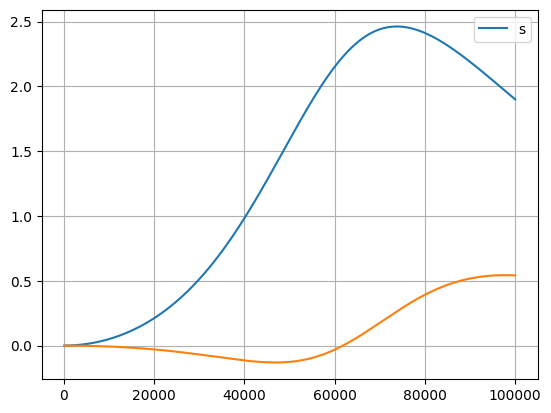

In [6]:
xi = 100   # Hz
xf = 100000  # Hz
xnum = 10000
x = np.linspace(xi,xf,xnum)

k = 0.2
y = [Calc_WTP(i,k,serie=False) for i in x]
print(y[60])
plt.plot(x,y)
plt.grid()
plt.legend("s")
plt.show()


## ETAPA 3 - Refinamento da função (Separação de tarefas e rodagem para mais valores)

#### Calculo da eficiência por Frequência de ressonância
Capacitores disponíveis:
$150nF; 0.1\mu F; 0.47\mu F; 1\mu F; 4.7\mu F$

In [29]:
#FUNÇÔES UTILIZADAS
def calcula_indutancia(w,c):
    return (1/w)**2/c

def impedancia(R,C,L,omega):
    Zc = 1/(1j*omega*C) # Impedância do capacitor
    Zl = 1j*omega*L # Impedância do indutor
    Zr = R # Impedância do resistor
    return Zc, Zl, Zr

def impedancia_ZM(L1,L2, K,omega):
    M = K * np.sqrt(L1*L2)
    Zm = 1j*omega*M
    return Zm


def CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf):
    # Cálculo da impedância total
    Z = np.array([[ZR1 + ZL1 + ZC1, -ZM], 
                  [-ZM, ZR2 + ZL2 + ((ZC2*Rc)/(ZC2+Rc))]]) 
    
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)  # Cálculo da corrente
    
    i1 = I[0]
    i2 = I[1]
    Zeq = Rc*ZC2/(Rc + ZC2)
    V2 = Zeq*i2   #tensao na saída

    # Potência de entrada (no primário)
    P_entrada = np.real(0.5*Uf * np.conj(i1))
    # Potência de saída (no secundário)
    P_saida = np.real(0.5* V2 * np.conj(i2))
    
    eficiencia = 100*P_saida/P_entrada if P_entrada > 0 else 0
    
    v2_abs = abs(V2)
    P_resistor = v2_abs**2/(2*Rc)

    return i1, i2, v2_abs, eficiencia, P_resistor

def CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf):
    # Cálculo da impedância total
    Z = np.array([[ZR1 + ZL1 + ZC1, -ZM], 
                  [-ZM, ZR2 + ZL2 + ZC2 + Rc ]])  
    
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)  # Cálculo da corrente
    
    i1 = I[0]
    i2 = I[1]
    
    V2 = Rc*i2  #tensao na saída
    
    #potencias
    # Potência de entrada (no primário)
    P_entrada = np.real(0.5*Uf * np.conj(i1))
    
    # Potência de saída (no secundário)
    P_saida = np.real(0.5* V2 * np.conj(i2))
    
    eficiencia = 100*P_saida/P_entrada if P_entrada != 0 else 0
    
    v2_abs = abs(V2)
    P_resistor = v2_abs**2/(2*Rc)

    return i1, i2, v2_abs, eficiencia, P_resistor

In [47]:
## DECLARAÇÃO DAS VARIAVEIS UTILIZADAS
capac_list = [150*(10**-9) , 0.1*(10**-6)  , 0.47*(10**-6) , 1*(10**-6), 4.7*(10**-6)] # Lista de valores de capacitor
frequencias = np.linspace(10000,40000,1000) #Valores de frequências possiveis
Uf = 12    # Tensão de entrada (V1)
Rc = 20     # Resistência de carga (R_C)
K = 0.2    # Coeficiente de acoplamento
R1 = 0.2 #Valor de 0.2 arbitrário e recomendado pelo professor, ainda não descoberta
R2 = 0.2 #Valor de 0.2 arbitrário e recomendado pelo professor, ainda não descoberta

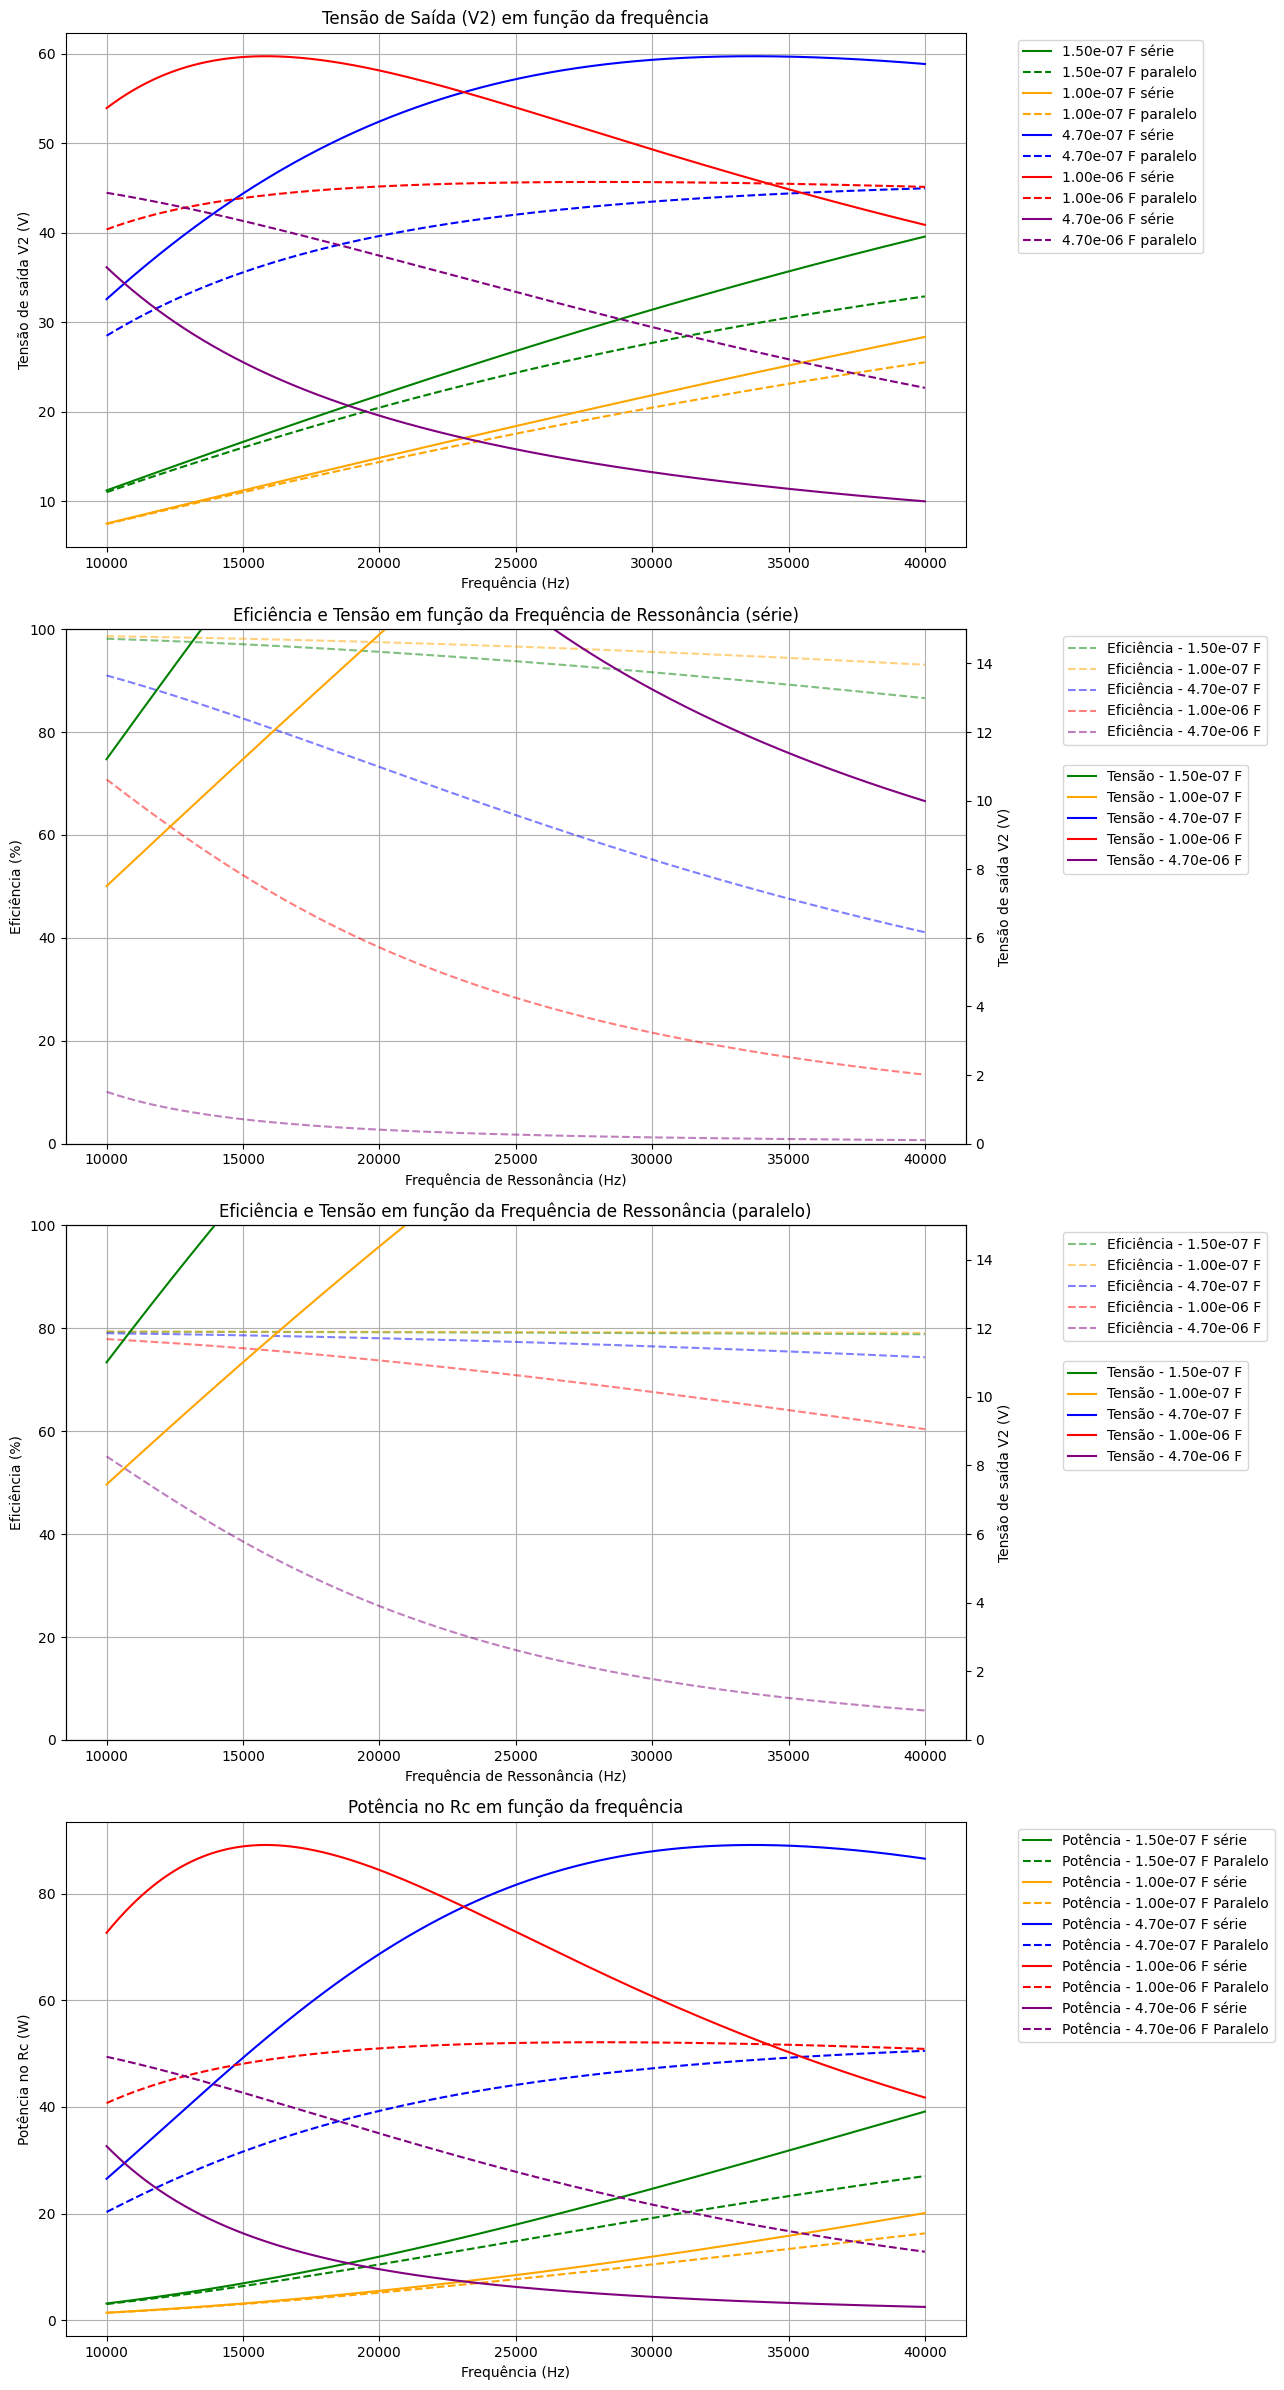

In [52]:
# Definição do estilo dos gráficos
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(13, 24))
cores = ['g', 'orange', 'b', 'r', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'lime']
linestyles = ['-', '--','-.']

ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()

for i, c in enumerate(capac_list):
    V_serie = []
    V_paralelo = []
    ef_serie = []
    ef_paralelo = []
    P_res_serie = []
    P_res_paralelo = []

    for freq in frequencias:
        #calculo dos componentes
        omega=2 * np.pi * freq
        L1 = calcula_indutancia(omega, c)
        L2 = calcula_indutancia(omega, c)
        ZC1, ZL1, ZR1 = impedancia(R1, c, L1, omega)
        ZC2, ZL2, ZR2 = impedancia(R2, c, L2, omega)
        ZM = impedancia_ZM(L1, L2, K, omega)

         # Calcular para paralelo
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_paralelo.append(V2)
        ef_paralelo.append(eficiencia)
        P_res_paralelo.append(P_res)
        
        # Calcular para série
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_serie.append(V2)
        ef_serie.append(eficiencia)
        P_res_serie.append(P_res)
    
    # Plotar tensão série e paralelo no primeiro gráfico (ax1)
    ax1.plot(frequencias, V_serie, label=f'{c:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax1.plot(frequencias, V_paralelo, label=f'{c:.2e} F paralelo', color=cores[i], linestyle=linestyles[1]) 

    # Plotar eficiência de serie no segundo gráfico (ax2)
    ax2.plot(frequencias, ef_serie, label=f'Eficiência - {c:.2e} F', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax2_twin.plot(frequencias, V_serie, label=f'Tensão - {c:.2e} F', color=cores[i], linestyle=linestyles[0])
    
    # Plotar eficiência de paralelo no terceiro gráfico (ax3)
    ax3.plot(frequencias, ef_paralelo, label=f'Eficiência - {c:.2e} F', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax3_twin.plot(frequencias, V_paralelo, label=f'Tensão - {c:.2e} F', color=cores[i], linestyle=linestyles[0])
    
    #plotando potencia
    ax4.plot(frequencias, P_res_serie, label=f'Potência - {c:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax4.plot(frequencias, P_res_paralelo, label=f'Potência - {c:.2e} F Paralelo', color=cores[i], linestyle=linestyles[1])

# Configurações do gráfico de tensões (ax1)
ax1.set_title("Tensão de Saída (V2) em função da frequência")
ax1.set_xlabel("Frequência (Hz)")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
#ax1.set_xlim(0, 100e3)  # Limite dos valores de frequêcia é até 100kHz
ax1.grid(True)

# Configurações do gráfico de eficiência (ax2)
ax2.set_title("Eficiência e Tensão em função da Frequência de Ressonância (série)")
ax2.set_xlabel("Frequência de Ressonância (Hz)")
ax2.set_ylabel("Eficiência (%)")
ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
#ax2.set_xlim(0, 100e3)
ax2.set_ylim(0, 100)
ax2.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax2
ax2_twin.set_ylabel("Tensão de saída V2 (V)")
ax2_twin.set_ylim(0, 15)
ax2_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

# Configurações do gráfico de eficiência (ax3)
ax3.set_title("Eficiência e Tensão em função da Frequência de Ressonância (paralelo)")
ax3.set_xlabel("Frequência de Ressonância (Hz)")
ax3.set_ylabel("Eficiência (%)")
ax3.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
#ax3.set_xlim(0, 100e3)
ax3.set_ylim(0, 100)
ax3.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax3
ax3_twin.set_ylabel("Tensão de saída V2 (V)")
ax3_twin.set_ylim(0, 15)
ax3_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

ax4.set_title("Potência no Rc em função da frequência")
ax4.set_xlabel("Frequência (Hz)")
ax4.set_ylabel("Potência no Rc (W)")
ax4.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
#ax4.set_xlim(0, 100e3)
ax4.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

    

### Seguindo o segundo e o terceiro gráfico foi estabelecido que a Frequencia escolhida foi de 15 Khz para uma tensão de saida de aproximadamente 11, com o capacitor de 0.1 mF



In [ ]:
#Segundo gráfico, definimos as variaveis para futuros testes
frequencia_escolhida=15000
c_escolhida=1e-7
Uf = 12    # Tensão de entrada (V1)
Rc = 20     # Resistência de carga (R_C)
K = 0.2    # Coeficiente de acoplamento
R1 = 0.2 #A DEFINIR SEGUNDO INDUTOR ESCOLHIDO
R2 = 0.2 #A DEFINIR SEGUNDO INDUTOR ESCOLHIDO
